In [ ]:
! pip install Finance-DataReader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
import tensorflow as tf
import FinanceDataReader as fdr
import cufflinks as cf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use("seaborn")

In [ ]:
class KDT:

    def MID(df):  # 중간값 추가하기
        high_prices = df['High'].values
        low_prices = df['Low'].values
        mid_prices = (high_prices + low_prices) / 2
        df['Mid'] = mid_prices


    def SMA_position(df, SMA_S, SMA_L) : # 단순이동평균
        i = df['Close'].rolling(window=SMA_S).mean()
        df['SMA%s' % SMA_S] = i
        i = df['Close'].rolling(window=SMA_L).mean()
        df['SMA%s' % SMA_L] = i
        df["SMA_position"] = np.where(df['SMA%s' %SMA_S] > df['SMA%s' %SMA_L], 1, -1)


    def Bollinger(df, SMA=30, dev=2) :
        df["SMA"] = df["Close"].rolling(SMA).mean()
        df["Lower"] = df["SMA"] - df["Close"].rolling(SMA).std() * dev # 상단 볼린저 밴드
        df["Upper"] = df["SMA"] + df["Close"].rolling(SMA).std() * dev # 하단 볼린저 밴드
        df["distance"] = df.Close - df.SMA 
        df["BB_position"] = np.where(df.Close < df.Lower, 1, np.nan) 
        df["BB_position"] = np.where(df.Close > df.Upper, -1, df["BB_position"]) 
        df["BB_position"] = np.where(df.distance * df.distance.shift(1) < 0, 0, df["BB_position"])
        df["BB_position"] = df.BB_position.ffill().fillna(0)


    def RSI(df):  # RSI 구하기      
        periods = 20
        df.Close.diff()
        df["U"] = np.where(df.Close.diff() > 0, df.Close.diff(), 0)
        df["D"] = np.where(df.Close.diff() < 0, -df.Close.diff(), 0)
        df["MA_U"] = df.U.rolling(periods).mean()
        df["MA_D"] = df.D.rolling(periods).mean()
        df["RSI"] = df.MA_U / (df.MA_U + df.MA_D) * 100

        rsi_upper = 70
        rsi_lower = 30

        df["RSI_position"] = np.where(df.RSI > rsi_upper, -1, np.nan) 
        df["RSI_position"] = np.where(df.RSI < rsi_lower, 1, df.RSI_position)
        df.RSI_position = df.RSI_position.fillna(0)


    def train_test_split_print(x_train, x_test, y_train, y_test):
        print('x_train shape : ', x_train.shape)
        print('y_train shape : ', y_train.shape)
        print('x_test shape : ', x_test.shape)
        print('y_test shape : ', y_test.shape)


    def returns(df, num):  # num 기간동안의 수익률
        df['returns%s' % num] =  df['Close'].pct_change(periods=num)


    def SMA(df) :     # %% 무작위 조합 알고리즘
        from scipy.optimize import brute
        import pandas as pd
        import numpy as np

        def run_strategy(SMA):
            data = df.copy()
            data["returns"] = np.log(data.Close.div(data.Close.shift(1)))
            data["SMA_S"] = data.Close.rolling(int(SMA[0])).mean()
            data["SMA_L"] = data.Close.rolling(int(SMA[1])).mean()
            data.dropna(inplace = True)
            
            data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
            data["strategy"] = data.position.shift(1) * data["returns"]
            data.dropna(inplace = True)
            
            return -data[["returns", "strategy"]].sum().apply(np.exp)[-1] # maximize absolute performance

        SMA_S, SMA_L = brute(run_strategy, ((5, 20, 1), (50, 252, 1)))
        return int(SMA_S), int(SMA_L)

   
    def MACD(df) :
        ema_s = 12 # EMA Short
        ema_l = 26 # EMA Long
        signal_mw = 9 # Moving Window for Signal Line

        df["EMA_S"] = df.Close.ewm(span = ema_s, min_periods = ema_s).mean()
        df["EMA_L"] = df.Close.ewm(span = ema_l, min_periods = ema_l).mean() 
        df["MACD"] = df.EMA_S - df.EMA_L
        df["MACD_Signal"] = df.MACD.ewm(span = signal_mw, min_periods = signal_mw).mean()
        df["MACD_position"] = np.where(df.MACD - df.MACD_Signal > 0, 1, -1)
    ### MACD 선이 이 시그널 라인을 넘어가면 롱 포지션으로 매수 시점이고
    ### MACD 선이 시그널 라인 밑으로 향하면 쇼트 포지션으로 매도 시점을 알립니다


    def KD(df) :
        periods = 14
        df["roll_low"] = df.Low.rolling(periods).min()
        df["roll_high"] = df.High.rolling(periods).max()
        df["K"] = (df.Close - df.roll_low) / (df.roll_high - df.roll_low) * 100 # K 지표
        moving_av = 3
        df["D"] = df.K.rolling(moving_av).mean() # D 지표
        df["KD_position"] = np.where(df["K"] > df["D"], 1, -1)
        ### K선이 D선을 위로 가로지를 때마다 매수하라는 신호
        ### K선이 D선을 아래로 가로지를 때마다 매도하라는 신호


    def comb_position(df) :
        df["comb_position"] = 0
        df["comb_position"] = np.where(df.MACD_position == 1, 1, 0)
        df["comb_position"] = np.where(
            df.RSI_position == 1, df.comb_position + 1, df.comb_position)
        df["comb_position"] = np.where(
            df.KD_position == 1, df.comb_position + 1, df.comb_position)
        df["comb_position"] = np.where(
            df.BB_position == 1, df.comb_position + 1, df.comb_position)


def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

## 종목 검색

In [ ]:
symbol = '041510'  # 원하는 종목 코드
start = "2010-01-01"  # 검색 시작일
end = "2022-12-31"  # 검색 종료일
df = fdr.DataReader(symbol, start, end)
df.info()
print('\n'*2, df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3065 entries, 2010-01-04 to 2022-06-03
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3065 non-null   int64  
 1   High    3065 non-null   int64  
 2   Low     3065 non-null   int64  
 3   Close   3065 non-null   int64  
 4   Volume  3065 non-null   int64  
 5   Change  3065 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 167.6 KB


              Open   High    Low  Close  Volume    Change
Date                                                    
2010-01-04   4008   4231   3892   4231  283495  0.056429
2010-01-05   4266   4578   4235   4445  753302  0.050579
2010-01-06   4418   4444   4186   4276  330498 -0.038020
2010-01-07   4320   4480   4181   4271  301811 -0.001169
2010-01-08   4271   4311   4034   4089  199189 -0.042613
...           ...    ...    ...    ...     ...       ...
2022-05-27  68300  70700  68000  68800  327575  0.017751
2022-05-30  

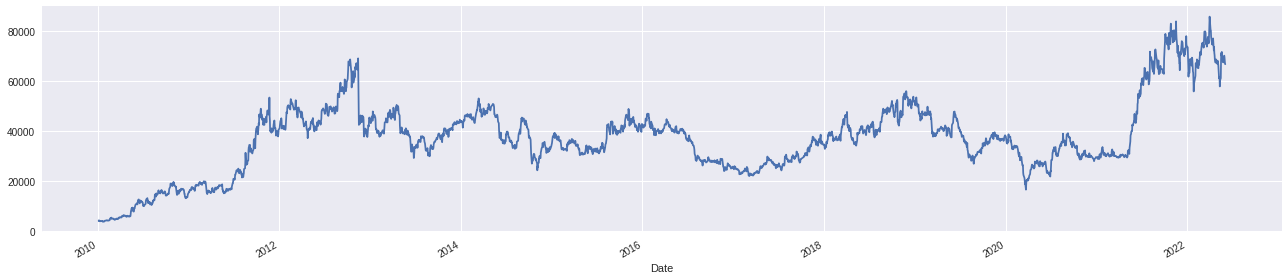

In [ ]:
plt.figure(figsize=(18,4))
df.Close.plot()
plt.tight_layout()

### 지표 추가
SMA, MACD, RSI, KD, Bollinger

In [ ]:
# SMA_S, SMA_L = KDT.SMA(df)
SMA_S, SMA_L = 5, 20
KDT.SMA_position(df, SMA_S, SMA_L)
KDT.MACD(df)
KDT.RSI(df)  # %% RSI 지표 추가하기
KDT.KD(df) # %%  SO 전략 K 지표, D 지표
KDT.Bollinger(df) # 볼린저 벤드
KDT.comb_position(df) # 조합 지표
KDT.returns(df, 5)

In [ ]:
print(df.RSI_position.value_counts())
print(df.comb_position.value_counts())

 0.0    2491
-1.0     331
 1.0     243
Name: RSI_position, dtype: int64
1    1332
2     950
0     559
3     207
4      17
Name: comb_position, dtype: int64


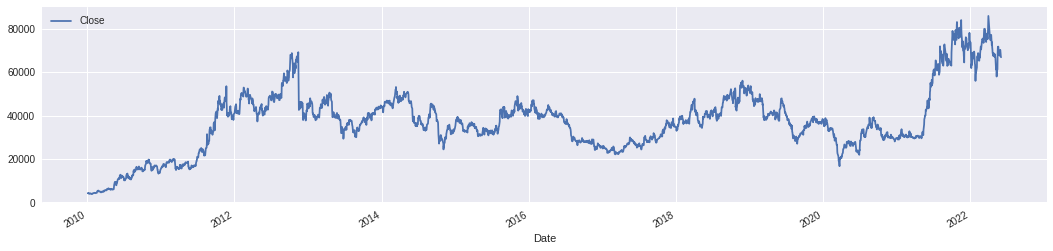

In [ ]:
plt.figure(figsize=(18,4))  # close 그래프
df.Close.plot()
plt.legend()
plt.show()

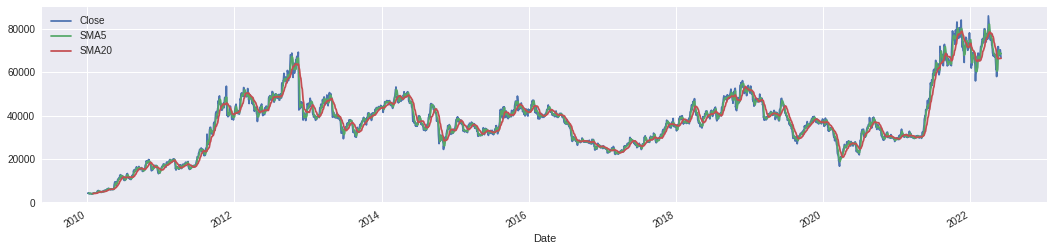

In [ ]:
plt.figure(figsize=(18,4))  # 이동평균선 그래프 
df['Close'].plot()
df['SMA%s' % SMA_S].plot()
df['SMA%s' % SMA_L].plot()
plt.legend()
plt.show()

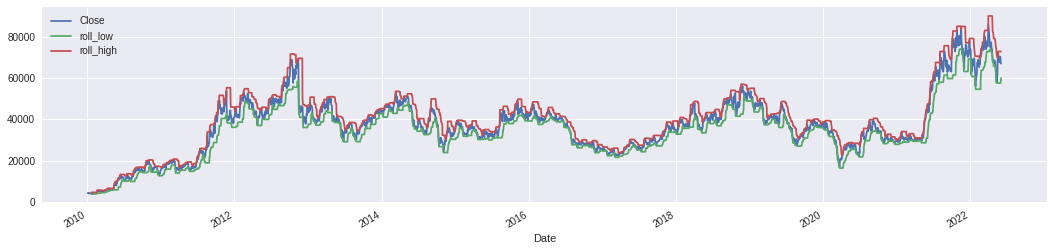

In [ ]:
plt.figure(figsize=(18,4))  # 
df['Close'].plot()
df['roll_low'].plot()
df['roll_high'].plot()
plt.legend()
plt.show()

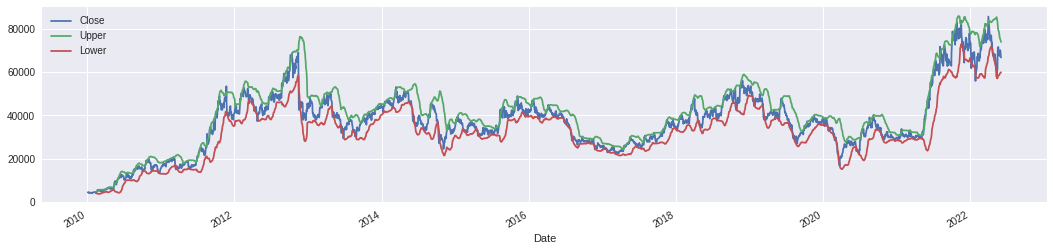

In [ ]:
plt.figure(figsize=(18,4))  #
df['Close'].plot()
df['Upper'].plot()
df['Lower'].plot()
plt.legend()
plt.show()

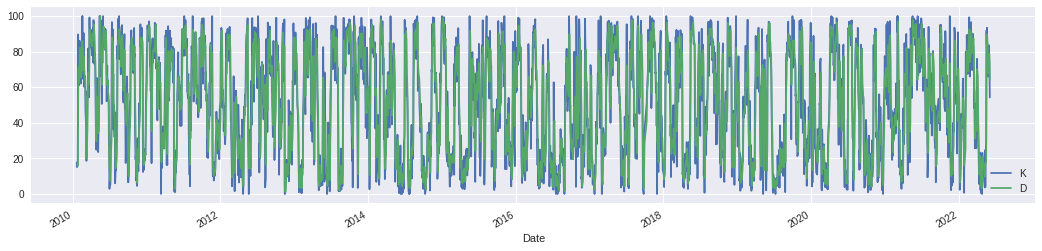

In [ ]:
plt.figure(figsize=(18,4))
df['K'].plot()
df['D'].plot()
plt.legend()
plt.show()

### 가격 예측

In [ ]:
series = df['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (3055, 10, 1) Y.shape (3055,)


### 모델

In [ ]:
i = Input(shape=(T, 1)) # 모델 설계
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 lstm_11 (LSTM)              (None, 5)                 140       
                                                                 
 dense_13 (Dense)            (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 컴파일
model.compile(loss = 'mse', optimizer = Adam(learning_rate=0.1), metrics=['accuracy'] ) 

In [ ]:
# 모델 학습
r = model.fit(X[:-N//2], Y[:-N//2], epochs=100, validation_data=(X[-N//2:], Y[-N//2:]), verbose = 0)

### 손실 시각화

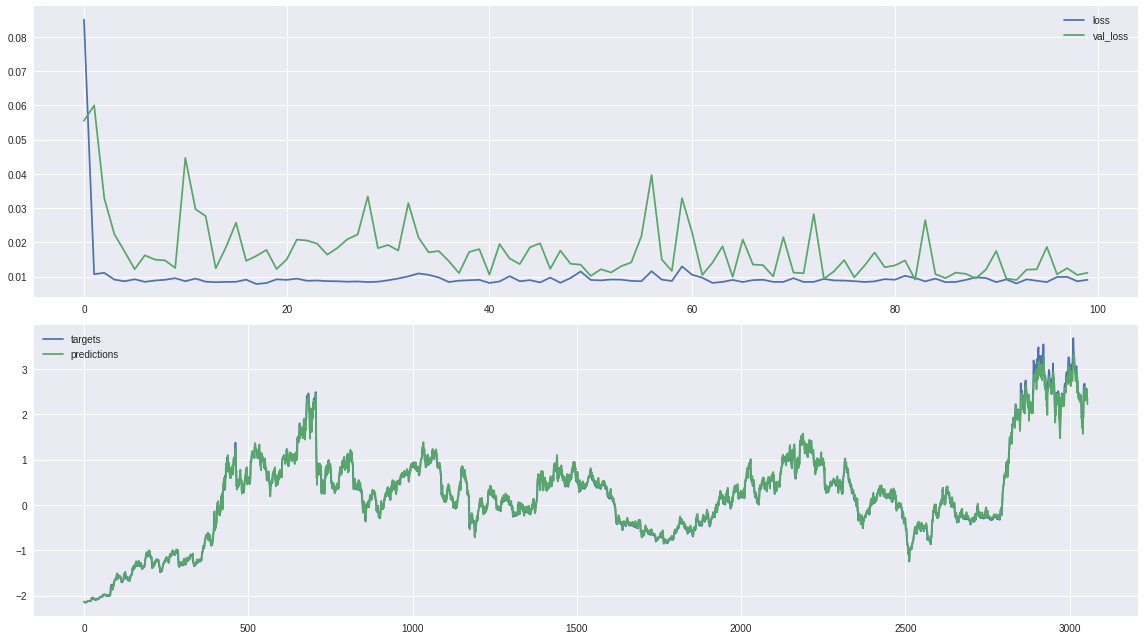

In [ ]:
outputs = model.predict(X)
predictions = outputs[:, 0]

fig=plt.figure()
fig.set_size_inches(16, 9)
ax1 = fig.add_subplot(211)
ax1.plot(r.history['loss'], label='loss')
ax1.plot(r.history['val_loss'], label='val_loss')
plt.legend()

ax2 = fig.add_subplot(212)
ax2.plot(Y, label='targets')
ax2.plot(predictions, label='predictions')
plt.legend()
plt.tight_layout()
plt.show()

## LogisticRegression

In [ ]:
sf = df[['SMA_position', 'RSI_position', 'KD_position', 'BB_position', 'comb_position', 'RSI']]
sf['Change_position'] = np.where(df["Change"] > 0, 1, 0)

sf["target"] = np.where(df.returns5 > 0.01, 1, np.nan)
sf["target"] = np.where(df.returns5 < 0.01, -1, sf.target)
sf.target = sf.target.fillna(-1)
sf["target"] = sf["target"].shift(-1)
sf = sf.dropna()

X = sf.iloc[:, 0:7]
y = sf.iloc[:, -1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
KDT.train_test_split_print(X_train, X_test, y_train, y_test)

logreg = LogisticRegression(max_iter=1000).fit(X_train, y_train)

x_train shape :  (2271, 7)
y_train shape :  (2271,)
x_test shape :  (758, 7)
y_test shape :  (758,)


In [ ]:
# print("prediction:", logreg.predict(X_test))
print("Train Data score : ", round(logreg.score(X_train, y_train), 3))
print("Test Data score : ", round(logreg.score(X_test, y_test), 3))

Train Data score :  0.64
Test Data score :  0.682


### 오차행렬 시각화

Confusion matrix, without normalization
[[379   0  48]
 [ 58   0  36]
 [ 99   0 138]]


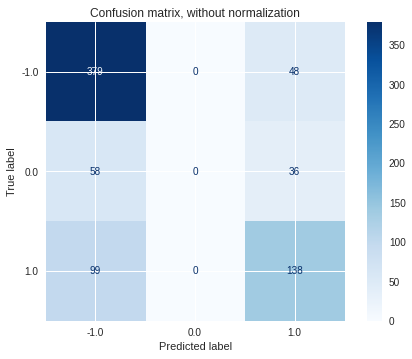

In [ ]:
titles_options = [("Confusion matrix, without normalization", None)]
for title, normalize in titles_options :
    disp = plot_confusion_matrix(logreg, X_test, y_test, cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
    # print(title)
    # print(disp.confusion_matrix)
plt.show()

#### 변수 있는거 다 넣어서 만듬

In [ ]:
df["target"] = sf["target"]
df = df.dropna()

X = df.iloc[:, 0:29]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= False)
KDT.train_test_split_print(X_train, X_test, y_train, y_test)

logreg = LogisticRegression(max_iter=8000).fit(X_train, y_train)

x_train shape :  (2272, 29)
y_train shape :  (2272,)
x_test shape :  (758, 29)
y_test shape :  (758,)


#### 분석결과 출력

In [ ]:
# print("prediction:", logreg.predict(X_test))
print("Train Data score : ", round(logreg.score(X_train, y_train), 3))
print("Test Data score: ", round(logreg.score(X_test, y_test), 3))

Train Data score :  0.839
Test Data score:  0.821


오차행렬 시각화

Confusion matrix, without normalization
[[348  77]
 [ 59 274]]


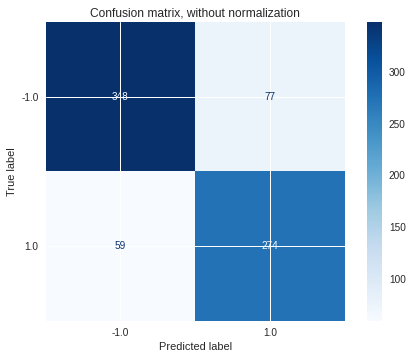

In [ ]:
titles_options = [("Confusion matrix, without normalization", None)]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(
        logreg, X_test, y_test, cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
plt.show()

In [ ]:
prediction = logreg.predict(X_test)
precision = precision_score(y_test, prediction, average="macro")
recalI = recall_score(y_test, prediction, average="macro")
# f1_scores = f1_score(y_test, prediction, average="macro")

print("precision:", round(precision, 4))
print("recall:", round(recalI, 4))
print("f1 score:", round(f1_score, 4 ))

precision: 0.8178
recall: 0.8208
f1 score: 0.844


### 부록

In [ ]:
start_date = df.index[-24]
end_date = df.index[-1]
nf = df[start_date:end_date]

print("올라갈 수 있을까? :", round((logreg.predict_proba(X_train)[-1][0]) * 100, 2))
print("리스크 :", round((nf.Change.std()) * 100, 2))
print("리턴 :", round((nf.Change.abs().sum()) * 100, 2))

올라갈 수 있을까? : 77.48
리스크 : 3.77
리턴 : 58.92


In [ ]:
nf["strategy"] = nf.target.shift(1) * nf["Change"]
nf["strategy_net"] = nf.strategy
nf["creturns"] = nf["Change"].cumsum().apply(np.exp)
nf["cstrategy"] = nf["strategy"].cumsum().apply(np.exp)
nf["cstrategy_net"] = nf["strategy_net"].cumsum().apply(np.exp)
nf = nf.dropna()

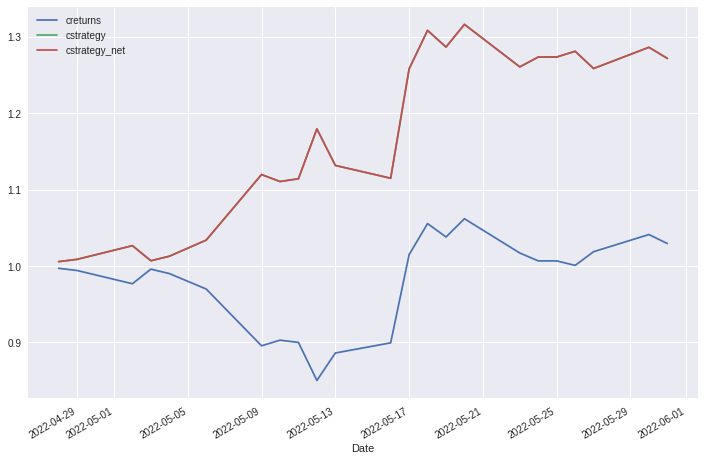

In [ ]:
nf[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12 , 8))
plt.show()

0    0.979801
1    0.977989
dtype: float64
0     867
1    2937
dtype: int64


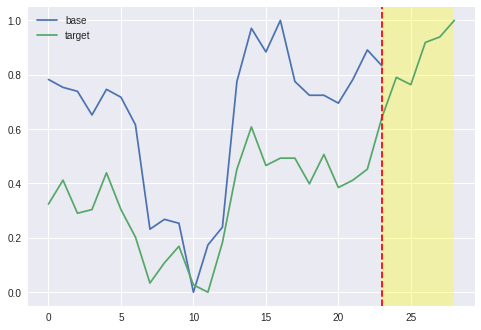

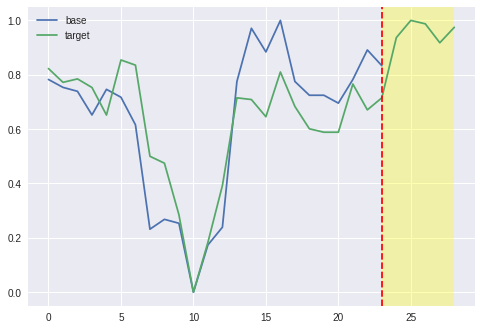

In [ ]:
close = df['Close']
base = close[start_date:end_date]
base

base_norm = (base - base.min()) / (base.max() - base.min())
base_norm

window_size = len(base)
next_date = 5
moving_cnt = len(close[:]) - window_size

sim_list = []
moving_cnts = []

def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

for i in range(moving_cnt):
    target = close[i:i+window_size]
    target_norm = (target - target.min()) / (target.max() - target.min())
    cos_similarity = cos_sim(base_norm, target_norm)
    if cos_similarity < 1.1 and cos_similarity > 0.975 :
        sim_list.append(cos_similarity)
        moving_cnts.append(i)

print(pd.Series(sim_list))
print(pd.Series(moving_cnts))

make_df = pd.DataFrame({'moving_cnts':moving_cnts, 'sim_list':sim_list})

for idx in moving_cnts :
    top_ = close[idx:idx+window_size+next_date]
    top_norm = (top_ - top_.min()) / (top_.max() - top_.min())

    plt.plot(base_norm.values, label='base')
    plt.plot(top_norm.values, label='target')
    plt.axvline(x=len(base_norm)-1, c='r', linestyle='--')
    plt.axvspan(len(base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
    plt.legend()
    plt.show()

In [ ]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'SMA5', 'SMA20',
       'SMA_position', 'EMA_S', 'EMA_L', 'MACD', 'MACD_Signal',
       'MACD_position', 'U', 'D', 'MA_U', 'MA_D', 'RSI', 'RSI_position',
       'roll_low', 'roll_high', 'K', 'KD_position', 'SMA', 'Lower', 'Upper',
       'distance', 'BB_position', 'comb_position', 'returns5', 'target'],
      dtype='object')

In [ ]:
kf = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'SMA5', 'SMA20', 'EMA_S', 'EMA_L', 'MACD', 'MACD_Signal', 'U', 'D', 'MA_U', 'MA_D', 'RSI', 'roll_low', 'roll_high', 'K', 'SMA', 'Lower', 'Upper','distance']]

In [ ]:
kf["target"] = sf["target"]
kf = kf.dropna()
X = kf.iloc[:, 0:24]
y = kf.iloc[:, 24]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= False)
KDT.train_test_split_print(X_train, X_test, y_train, y_test)
logreg = LogisticRegression(max_iter=5000).fit(X_train, y_train)

x_train shape :  (2272, 24)
y_train shape :  (2272,)
x_test shape :  (758, 24)
y_test shape :  (758,)


Train Data score :  0.833
Test Data score :  0.819
Confusion matrix, without normalization
[[348  77]
 [ 60 273]]


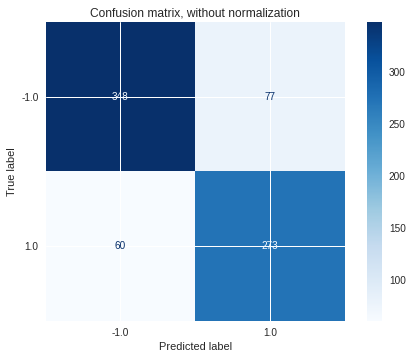

In [ ]:
# print("prediction:", logreg.predict(X_test))
print("Train Data score : ", round(logreg.score(X_train, y_train), 3))
print("Test Data score : ", round(logreg.score(X_test, y_test), 3))

titles_options = [("Confusion matrix, without normalization", None)]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(
        logreg, X_test, y_test, cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
plt.show()